# Life Expectancy Prediction
### WHO Global Health Data (2000-2015)

Analyzing factors affecting life expectancy across 193 countries using machine learning.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print('Libraries loaded successfully')

Libraries loaded successfully


## 2. Load Dataset

In [2]:
df = pd.read_csv('/content/Life_Expectancy_Data.csv')

print(f'Dataset shape: {df.shape}')
print(f'Countries: {df["Country"].nunique()}')
print(f'Years: {df["Year"].min()} to {df["Year"].max()}')

Dataset shape: (2938, 22)
Countries: 193
Years: 2000 to 2015


In [3]:
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

## 3. Data Exploration

In [5]:
# check missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(1)
missing_info = pd.DataFrame({'count': missing, 'percent': missing_pct})
missing_info[missing_info['count'] > 0].sort_values('count', ascending=False)

,count,percent
Population,652,22.2
Hepatitis B,553,18.8
GDP,448,15.2
Total expenditure,226,7.7
Alcohol,194,6.6
Income composition of resources,167,5.7
Schooling,163,5.5
thinness 5-9 years,34,1.2
thinness 1-19 years,34,1.2
BMI,34,1.2


In [6]:
# target variable
target = 'Life expectancy '

print('Life Expectancy Stats:')
print(f'  Mean: {df[target].mean():.1f} years')
print(f'  Median: {df[target].median():.1f} years')
print(f'  Min: {df[target].min():.1f} years')
print(f'  Max: {df[target].max():.1f} years')
print(f'  Std: {df[target].std():.1f} years')

Life Expectancy Stats:
  Mean: 69.2 years
  Median: 72.1 years
  Min: 36.3 years
  Max: 89.0 years
  Std: 9.5 years


In [7]:
# development status breakdown
print('Development Status:')
print(df['Status'].value_counts())
print(f'\nDeveloped: {(df["Status"] == "Developed").sum() / len(df) * 100:.1f}%')
print(f'Developing: {(df["Status"] == "Developing").sum() / len(df) * 100:.1f}%')

Development Status:
Status
Developing    2426
Developed      512
Name: count, dtype: int64

Developed: 17.4%
Developing: 82.6%


In [8]:
df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


## 4. Data Visualization

In [9]:
# create visualizations folder
import os
os.makedirs('visualizations', exist_ok=True)

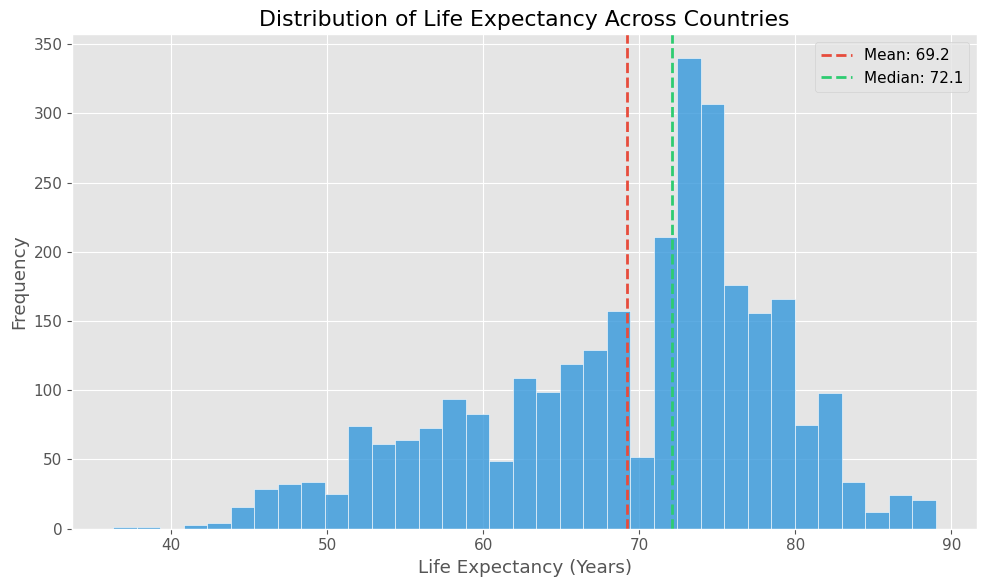

In [10]:
# 1. life expectancy distribution
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df[target].dropna(), bins=35, color='#3498db', edgecolor='white', alpha=0.8)
ax.axvline(df[target].mean(), color='#e74c3c', linestyle='--', lw=2, label=f'Mean: {df[target].mean():.1f}')
ax.axvline(df[target].median(), color='#2ecc71', linestyle='--', lw=2, label=f'Median: {df[target].median():.1f}')
ax.set_xlabel('Life Expectancy (Years)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Life Expectancy Across Countries')
ax.legend()
plt.tight_layout()
plt.savefig('visualizations/01_distribution.png', dpi=150)
plt.show()

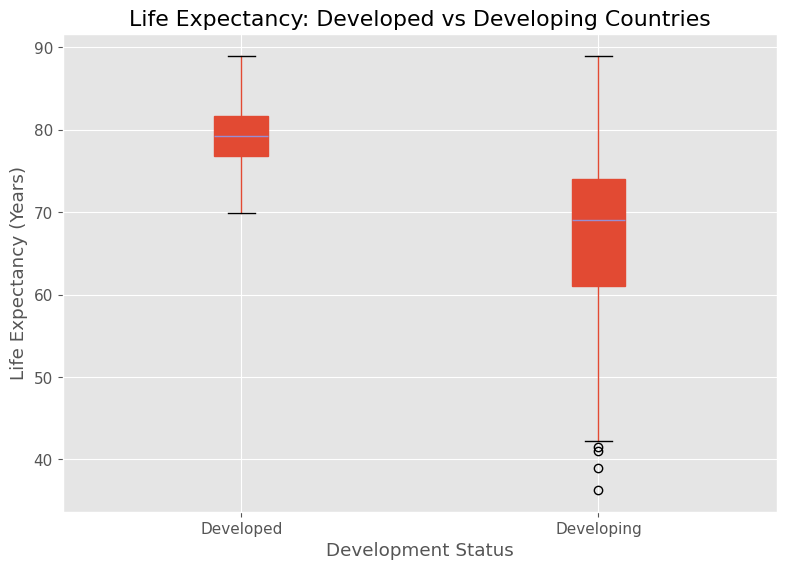

In [11]:
# 2. boxplot by status
fig, ax = plt.subplots(figsize=(8, 6))
df.boxplot(column=target, by='Status', ax=ax, patch_artist=True)
plt.suptitle('')
ax.set_title('Life Expectancy: Developed vs Developing Countries')
ax.set_xlabel('Development Status')
ax.set_ylabel('Life Expectancy (Years)')
plt.tight_layout()
plt.savefig('visualizations/02_boxplot_status.png', dpi=150)
plt.show()

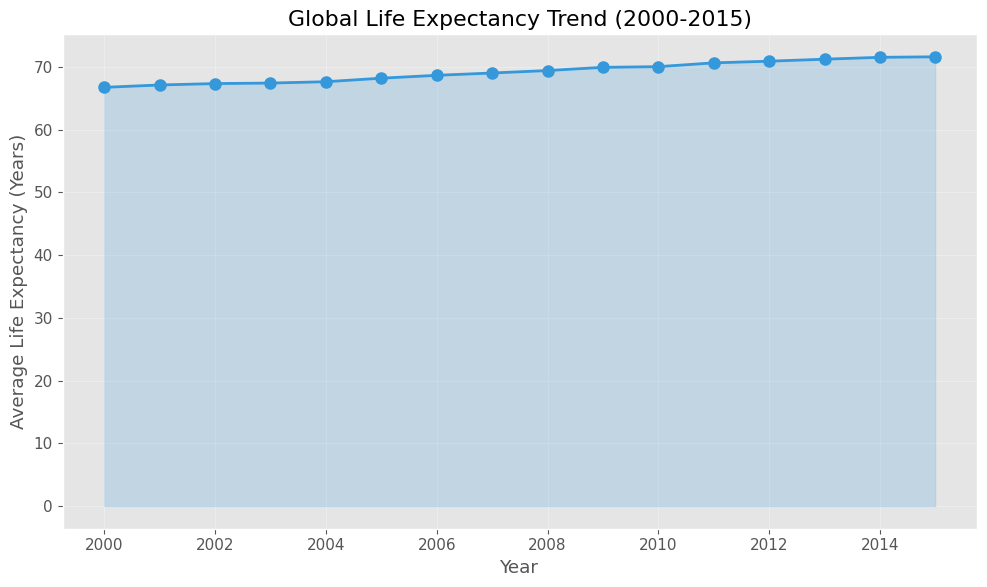

In [12]:
# 3. yearly trend
yearly = df.groupby('Year')[target].mean()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(yearly.index, yearly.values, marker='o', markersize=8, linewidth=2, color='#3498db')
ax.fill_between(yearly.index, yearly.values, alpha=0.2, color='#3498db')
ax.set_xlabel('Year')
ax.set_ylabel('Average Life Expectancy (Years)')
ax.set_title('Global Life Expectancy Trend (2000-2015)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/03_yearly_trend.png', dpi=150)
plt.show()

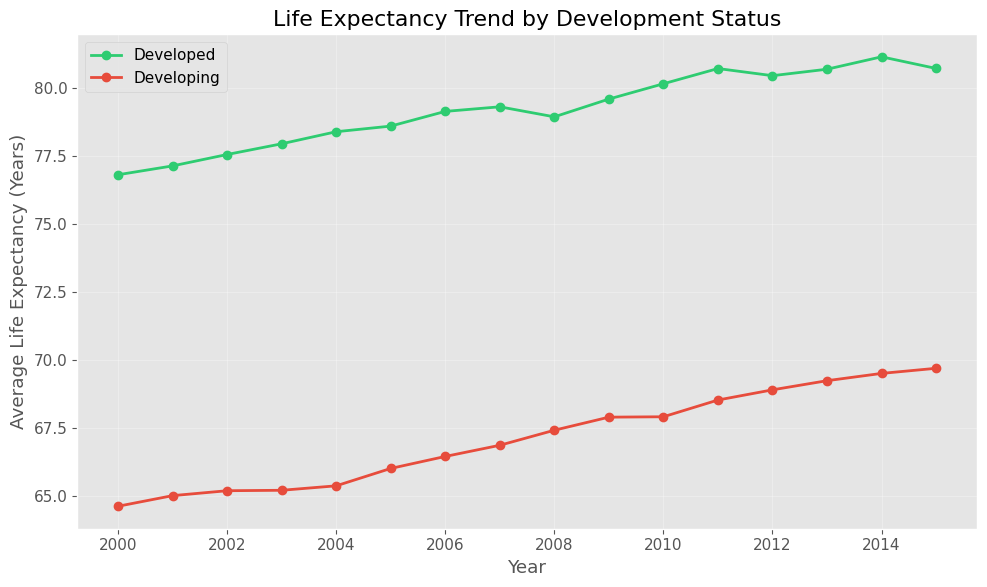

In [13]:
# 4. trend by development status
fig, ax = plt.subplots(figsize=(10, 6))
for status, color in [('Developed', '#2ecc71'), ('Developing', '#e74c3c')]:
    data = df[df['Status'] == status].groupby('Year')[target].mean()
    ax.plot(data.index, data.values, marker='o', linewidth=2, label=status, color=color)

ax.set_xlabel('Year')
ax.set_ylabel('Average Life Expectancy (Years)')
ax.set_title('Life Expectancy Trend by Development Status')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/04_trend_by_status.png', dpi=150)
plt.show()

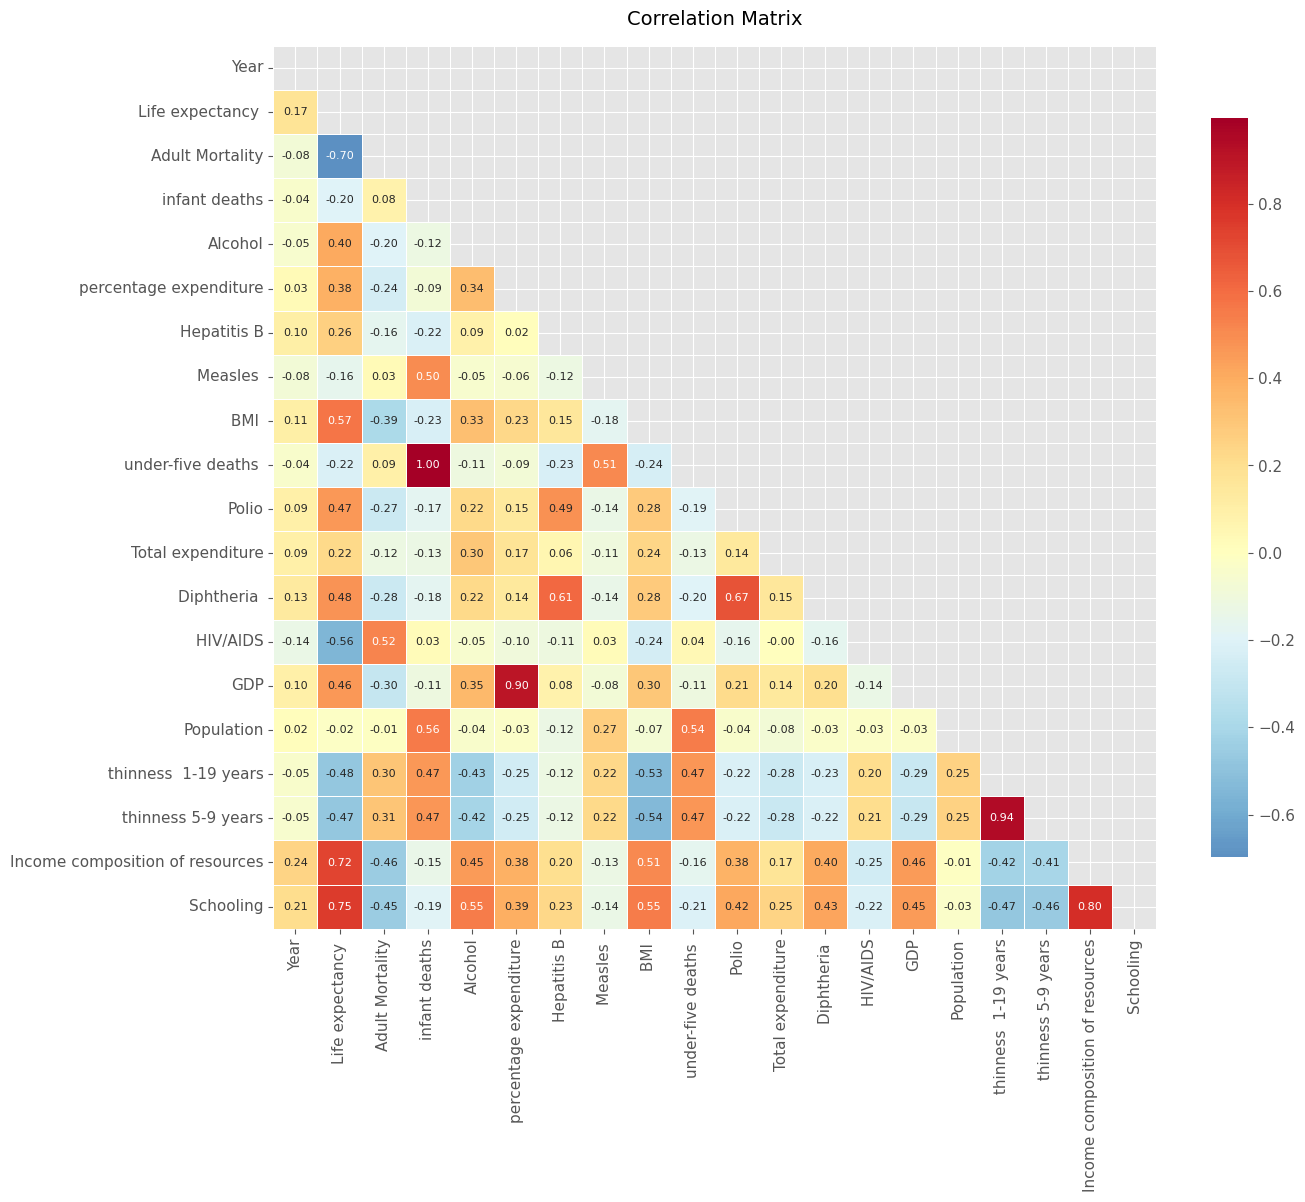

In [14]:
# 5. correlation heatmap
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdYlBu_r',
            center=0, square=True, linewidths=0.5, ax=ax,
            annot_kws={'size': 8}, cbar_kws={'shrink': 0.8})
ax.set_title('Correlation Matrix', fontsize=14, pad=15)
plt.tight_layout()
plt.savefig('visualizations/05_correlation_heatmap.png', dpi=150)
plt.show()

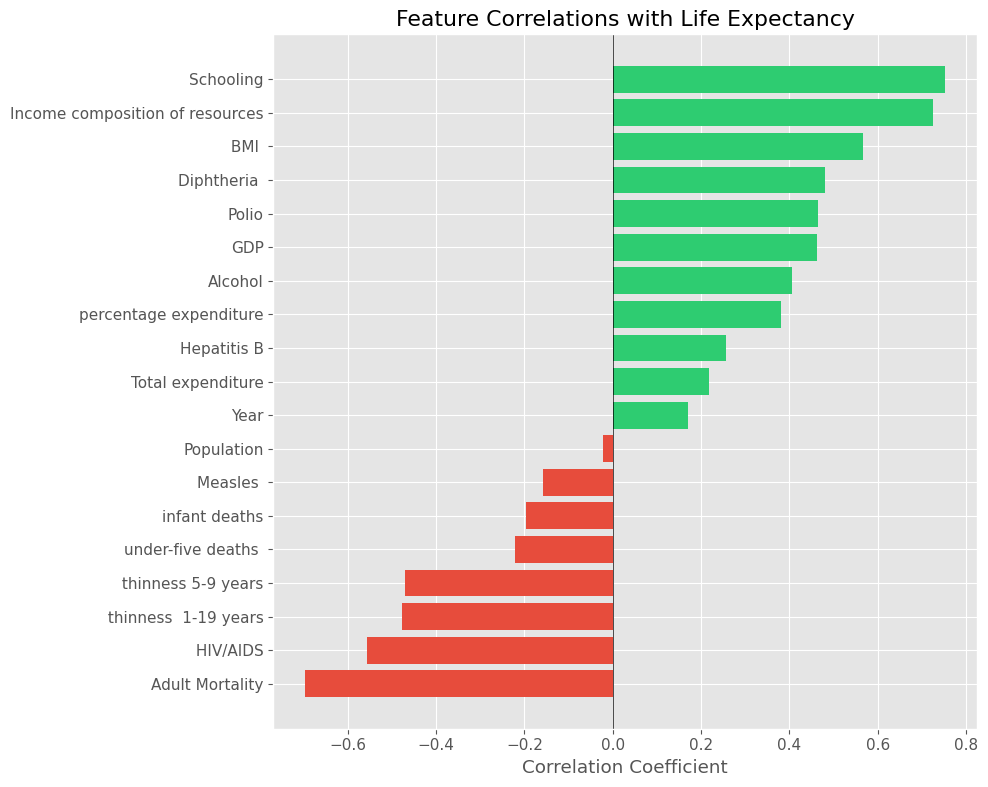

In [15]:
# 6. feature correlations with life expectancy
life_corr = corr[target].drop(target).sort_values()

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in life_corr.values]
ax.barh(life_corr.index, life_corr.values, color=colors)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('Correlation Coefficient')
ax.set_title('Feature Correlations with Life Expectancy')
plt.tight_layout()
plt.savefig('visualizations/06_feature_correlations.png', dpi=150)
plt.show()

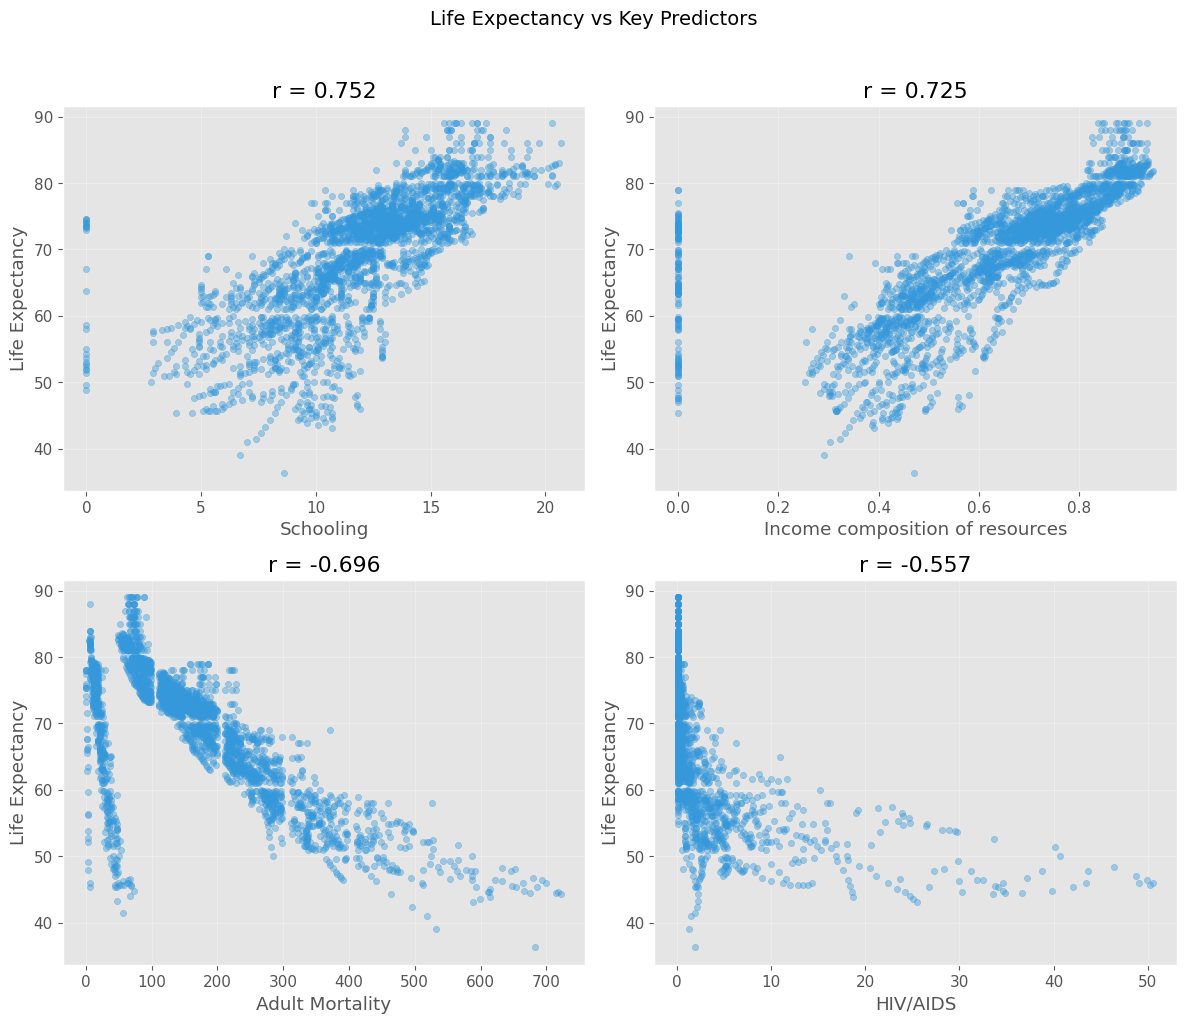

In [16]:
# 7. scatter plots for key features
key_features = ['Schooling', 'Income composition of resources', 'Adult Mortality', ' HIV/AIDS']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, feat in enumerate(key_features):
    if feat in df.columns:
        axes[i].scatter(df[feat], df[target], alpha=0.4, s=20, c='#3498db')
        corr_val = df[[feat, target]].corr().iloc[0, 1]
        axes[i].set_xlabel(feat.strip())
        axes[i].set_ylabel('Life Expectancy')
        axes[i].set_title(f'r = {corr_val:.3f}')
        axes[i].grid(True, alpha=0.3)

plt.suptitle('Life Expectancy vs Key Predictors', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('visualizations/07_scatter_plots.png', dpi=150)
plt.show()

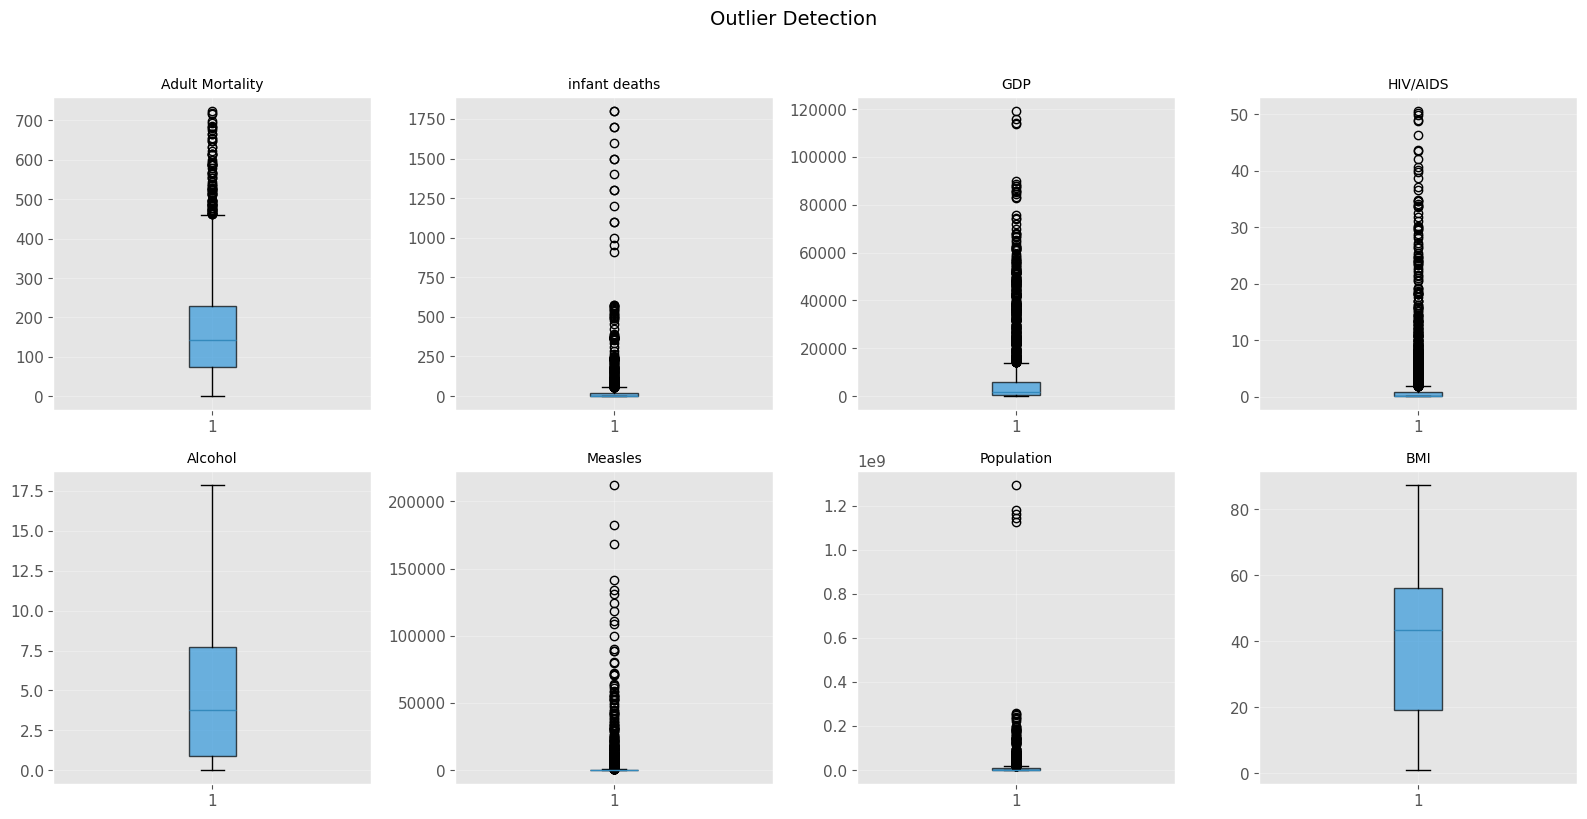

In [17]:
# 8. outlier detection
outlier_cols = ['Adult Mortality', 'infant deaths', 'GDP', ' HIV/AIDS',
                'Alcohol', 'Measles ', 'Population', ' BMI ']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(outlier_cols):
    if col in df.columns:
        axes[i].boxplot(df[col].dropna(), patch_artist=True,
                       boxprops=dict(facecolor='#3498db', alpha=0.7))
        axes[i].set_title(col.strip(), fontsize=10)
        axes[i].grid(True, alpha=0.3)

plt.suptitle('Outlier Detection', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('visualizations/08_outliers.png', dpi=150)
plt.show()

## 5. Data Cleaning

In [18]:
df_clean = df.copy()
print(f'Original missing values: {df_clean.isnull().sum().sum()}')

Original missing values: 2563


In [19]:
# fill missing values with mean
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='mean')

for col in numeric_cols:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col] = imputer.fit_transform(df_clean[[col]])

print(f'Missing values after imputation: {df_clean.isnull().sum().sum()}')

Missing values after imputation: 0


In [20]:
# handle outliers using IQR method
outlier_cols = ['Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure',
                'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio',
                'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
                ' thinness  1-19 years', ' thinness 5-9 years',
                'Income composition of resources', 'Schooling']

outliers_fixed = 0
for col in outlier_cols:
    if col in df_clean.columns:
        q1 = df_clean[col].quantile(0.25)
        q3 = df_clean[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        outliers = ((df_clean[col] < lower) | (df_clean[col] > upper)).sum()
        outliers_fixed += outliers

        col_mean = df_clean[col].mean()
        df_clean[col] = np.where((df_clean[col] < lower) | (df_clean[col] > upper),
                                  col_mean, df_clean[col])

print(f'Outliers replaced: {outliers_fixed}')

Outliers replaced: 4115


In [21]:
# encode categorical variables
le = LabelEncoder()
df_clean['Status_Encoded'] = le.fit_transform(df_clean['Status'])
df_clean['Country_Encoded'] = le.fit_transform(df_clean['Country'])

print('Encoding:')
print('  Developed = 0')
print('  Developing = 1')

Encoding:
  Developed = 0
  Developing = 1


In [22]:
# create new features
df_clean['Mortality_Ratio'] = df_clean['Adult Mortality'] / (df_clean['infant deaths'] + 1)
df_clean['Immunization_Score'] = (df_clean['Polio'] + df_clean['Diphtheria '] + df_clean['Hepatitis B']) / 3
df_clean['GDP_Income'] = df_clean['GDP'] * df_clean['Income composition of resources']

print('New features created:')
print('  - Mortality_Ratio')
print('  - Immunization_Score')
print('  - GDP_Income')

New features created:
  - Mortality_Ratio
  - Immunization_Score
  - GDP_Income


In [23]:
# save cleaned data
os.makedirs('cleaned_data', exist_ok=True)
df_clean.to_csv('cleaned_data/life_expectancy_cleaned.csv', index=False)
print('Saved: cleaned_data/life_expectancy_cleaned.csv')

Saved: cleaned_data/life_expectancy_cleaned.csv


In [24]:
df_clean.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status_Encoded,Country_Encoded,Mortality_Ratio,Immunization_Score,GDP_Income
0,Afghanistan,2015,Developing,65.0,263.0,30.303948,0.01,71.279624,65.0,2419.59224,...,1.275338e+07,4.839704,4.870317,0.479,10.1,1,0,8.401496,70.850063,279.860162
1,Afghanistan,2014,Developing,59.9,271.0,30.303948,0.01,73.523582,62.0,492.00000,...,3.275820e+05,4.839704,4.870317,0.476,10.0,1,0,8.657055,60.666667,291.643541
2,Afghanistan,2013,Developing,59.9,268.0,30.303948,0.01,73.219243,64.0,430.00000,...,1.275338e+07,4.839704,4.870317,0.470,9.9,1,0,8.561220,63.333333,296.920139
3,Afghanistan,2012,Developing,59.5,272.0,30.303948,0.01,78.184215,67.0,2419.59224,...,3.696958e+06,4.839704,4.870317,0.463,9.8,1,0,8.689000,67.000000,310.191017
4,Afghanistan,2011,Developing,59.2,275.0,30.303948,0.01,7.097109,68.0,2419.59224,...,2.978599e+06,4.839704,4.870317,0.454,9.5,1,0,8.784834,68.000000,28.845903


## 6. Model Building

In [25]:
# prepare features
feature_cols = ['Year', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure',
                'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio',
                'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
                ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources',
                'Schooling', 'Status_Encoded', 'Mortality_Ratio', 'Immunization_Score', 'GDP_Income']

feature_cols = [c for c in feature_cols if c in df_clean.columns]

X = df_clean[feature_cols]
y = df_clean[target]

print(f'Features: {len(feature_cols)}')
print(f'Samples: {len(X)}')

Features: 23
Samples: 2938


In [26]:
# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f'Training samples: {len(X_train)}')
print(f'Test samples: {len(X_test)}')

Training samples: 2350
Test samples: 588


In [27]:
# train multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results.append({
        'Model': name,
        'R2_Score': round(r2, 4),
        'RMSE': round(rmse, 4),
        'MAE': round(mae, 4)
    })
    print(f'{name}: R² = {r2:.4f}, RMSE = {rmse:.2f}')

results_df = pd.DataFrame(results).sort_values('R2_Score', ascending=False)
results_df

Linear Regression: R² = 0.8533, RMSE = 3.57
Ridge: R² = 0.8533, RMSE = 3.56
Random Forest: R² = 0.9658, RMSE = 1.72
Extra Trees: R² = 0.9739, RMSE = 1.50
Gradient Boosting: R² = 0.9446, RMSE = 2.19


,Model,R2_Score,RMSE,MAE
3,Extra Trees,0.9739,1.5031,0.9098
2,Random Forest,0.9658,1.7223,1.0821
4,Gradient Boosting,0.9446,2.1903,1.6124
0,Linear Regression,0.8533,3.5655,2.6845
1,Ridge,0.8533,3.5645,2.6837


In [28]:
# save model results
results_df.to_csv('cleaned_data/model_results.csv', index=False)
print('Saved: cleaned_data/model_results.csv')

Saved: cleaned_data/model_results.csv


In [29]:
# best model
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f'Best Model: {best_model_name}')
print(f'R² Score: {results_df.iloc[0]["R2_Score"]}')
print(f'RMSE: {results_df.iloc[0]["RMSE"]} years')

Best Model: Extra Trees
R² Score: 0.9739
RMSE: 1.5031 years


In [30]:
# cross validation
cv_scores = cross_val_score(best_model, X_scaled, y, cv=10, scoring='r2')

print('10-Fold Cross Validation:')
print(f'  Mean R²: {cv_scores.mean():.4f}')
print(f'  Std: {cv_scores.std():.4f}')
print(f'  Min: {cv_scores.min():.4f}')
print(f'  Max: {cv_scores.max():.4f}')

10-Fold Cross Validation:
  Mean R²: 0.8977
  Std: 0.0325
  Min: 0.8259
  Max: 0.9361


## 7. Model Evaluation

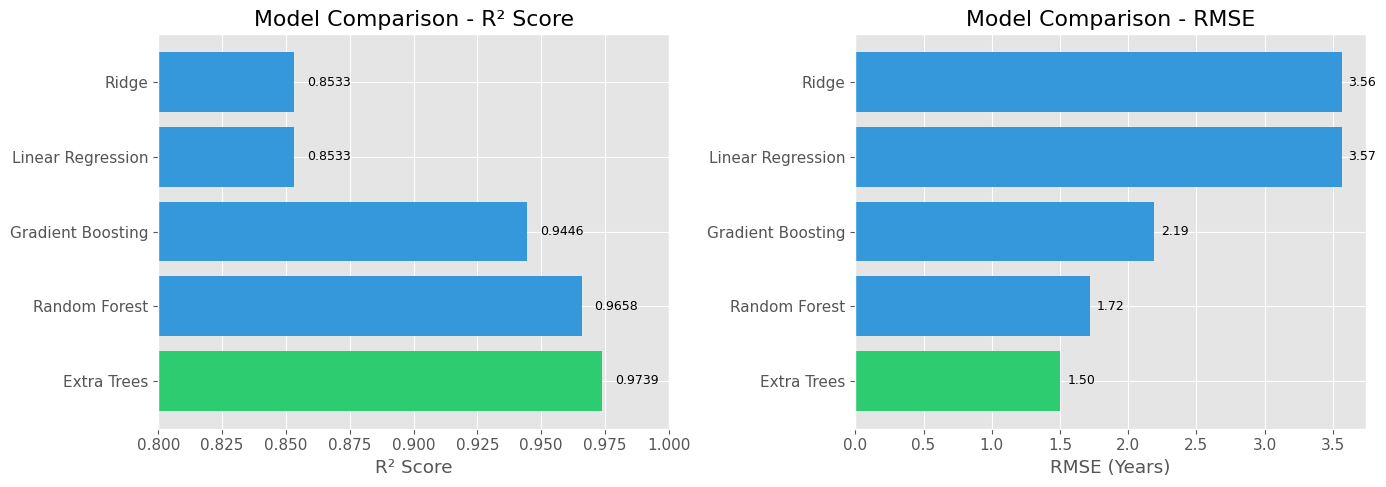

In [31]:
# 9. model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#2ecc71' if m == best_model_name else '#3498db' for m in results_df['Model']]

# R2 scores
axes[0].barh(results_df['Model'], results_df['R2_Score'], color=colors)
axes[0].set_xlabel('R² Score')
axes[0].set_title('Model Comparison - R² Score')
axes[0].set_xlim(0.8, 1.0)
for i, v in enumerate(results_df['R2_Score']):
    axes[0].text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=9)

# RMSE
axes[1].barh(results_df['Model'], results_df['RMSE'], color=colors)
axes[1].set_xlabel('RMSE (Years)')
axes[1].set_title('Model Comparison - RMSE')
for i, v in enumerate(results_df['RMSE']):
    axes[1].text(v + 0.05, i, f'{v:.2f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('visualizations/09_model_comparison.png', dpi=150)
plt.show()

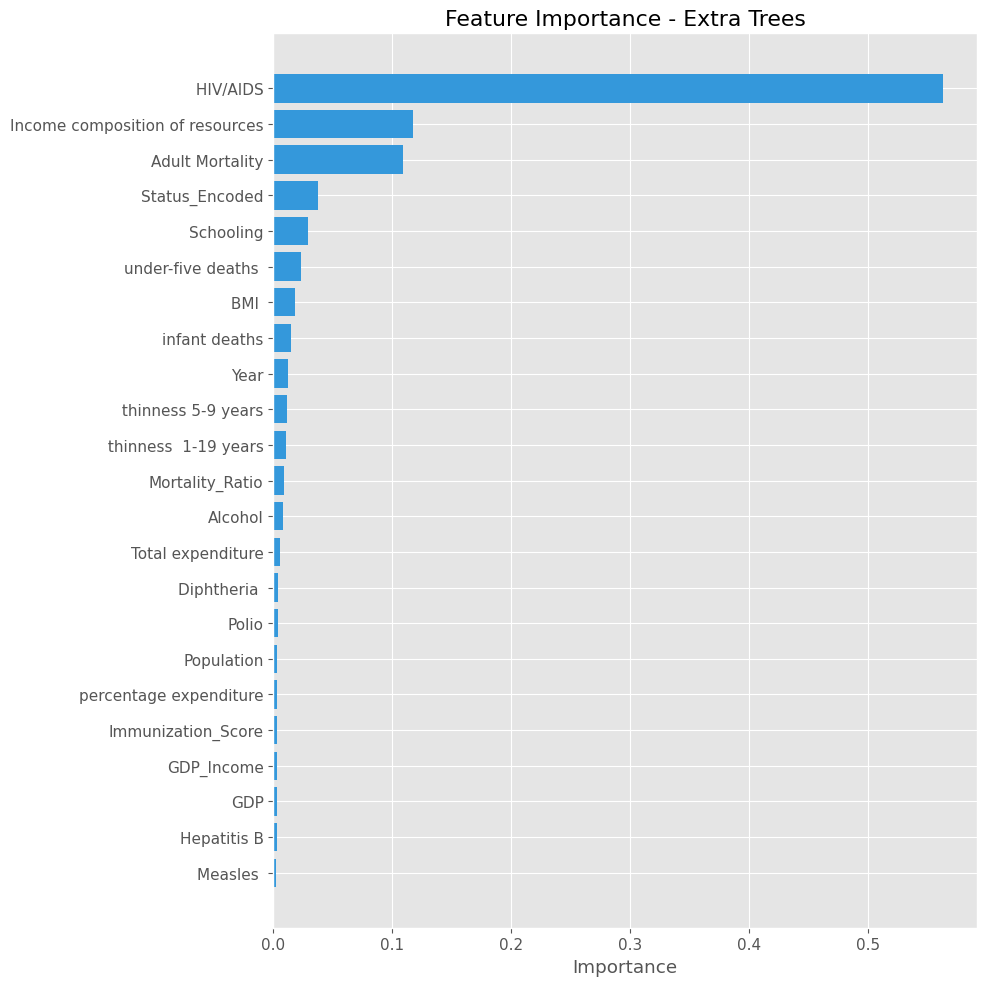

Saved: cleaned_data/feature_importance.csv


In [32]:
# 10. feature importance
if hasattr(best_model, 'feature_importances_'):
    importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=True)

    importance.sort_values('Importance', ascending=False).to_csv('cleaned_data/feature_importance.csv', index=False)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.barh(importance['Feature'], importance['Importance'], color='#3498db')
    ax.set_xlabel('Importance')
    ax.set_title(f'Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.savefig('visualizations/10_feature_importance.png', dpi=150)
    plt.show()

    print('Saved: cleaned_data/feature_importance.csv')

In [33]:
# top 10 important features
importance.sort_values('Importance', ascending=False).head(10)

,Feature,Importance
12,HIV/AIDS,0.563800
17,Income composition of resources,0.117097
1,Adult Mortality,0.109254
19,Status_Encoded,0.037424
18,Schooling,0.028771
8,under-five deaths,0.022989
7,BMI,0.018181
2,infant deaths,0.014516
0,Year,0.012397
16,thinness 5-9 years,0.011468


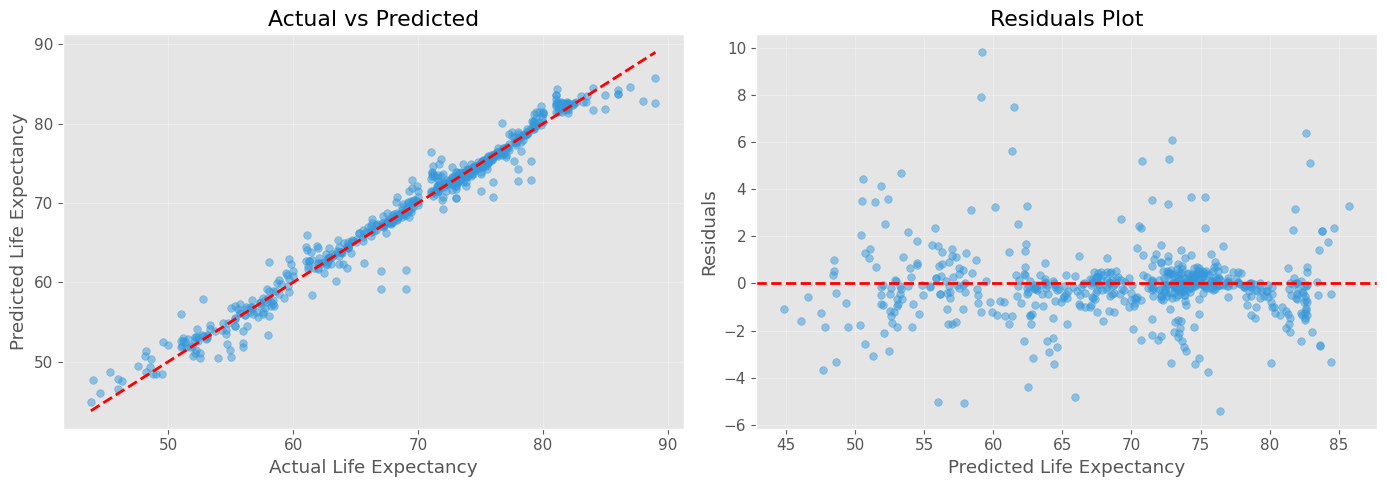

In [34]:
# 11. actual vs predicted
y_pred_best = best_model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# scatter
axes[0].scatter(y_test, y_pred_best, alpha=0.5, s=30, c='#3498db')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Life Expectancy')
axes[0].set_ylabel('Predicted Life Expectancy')
axes[0].set_title('Actual vs Predicted')
axes[0].grid(True, alpha=0.3)

# residuals
residuals = y_test - y_pred_best
axes[1].scatter(y_pred_best, residuals, alpha=0.5, s=30, c='#3498db')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Life Expectancy')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residuals Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/11_predictions.png', dpi=150)
plt.show()

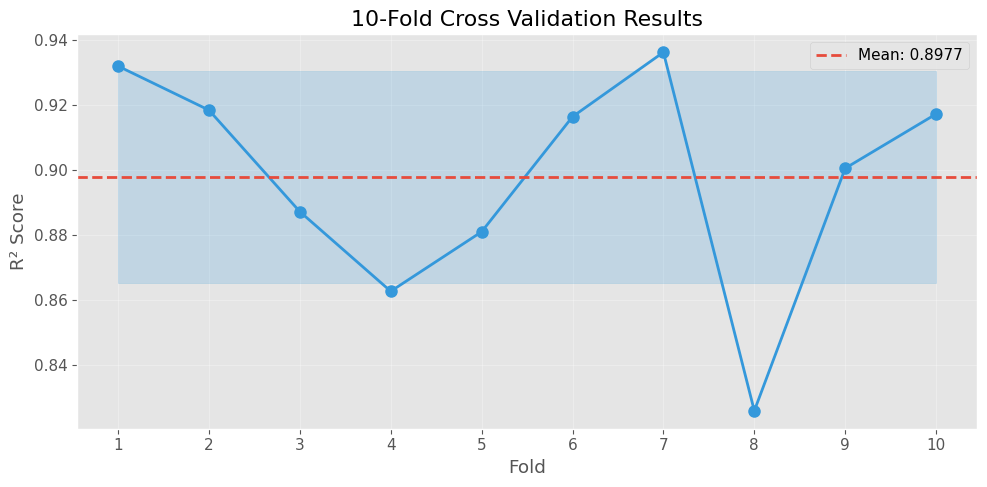

In [35]:
# 12. cross validation plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(1, 11), cv_scores, marker='o', linewidth=2, markersize=8, color='#3498db')
ax.axhline(cv_scores.mean(), color='#e74c3c', linestyle='--', lw=2, label=f'Mean: {cv_scores.mean():.4f}')
ax.fill_between(range(1, 11), cv_scores.mean() - cv_scores.std(), cv_scores.mean() + cv_scores.std(),
                alpha=0.2, color='#3498db')
ax.set_xlabel('Fold')
ax.set_ylabel('R² Score')
ax.set_title('10-Fold Cross Validation Results')
ax.set_xticks(range(1, 11))
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/12_cross_validation.png', dpi=150)
plt.show()

## 8. Statistical Analysis

In [36]:
# t-test: developed vs developing
developed = df_clean[df_clean['Status'] == 'Developed'][target]
developing = df_clean[df_clean['Status'] == 'Developing'][target]

t_stat, p_val = stats.ttest_ind(developed, developing)

print('T-Test: Developed vs Developing')
print(f'  Developed mean: {developed.mean():.2f} years')
print(f'  Developing mean: {developing.mean():.2f} years')
print(f'  Difference: {developed.mean() - developing.mean():.2f} years')
print(f'  T-statistic: {t_stat:.2f}')
print(f'  P-value: {p_val:.2e}')
print(f'  Result: {"Significant" if p_val < 0.05 else "Not Significant"} at α=0.05')

T-Test: Developed vs Developing
  Developed mean: 79.20 years
  Developing mean: 67.12 years
  Difference: 12.08 years
  T-statistic: 29.81
  P-value: 9.03e-171
  Result: Significant at α=0.05


In [37]:
# top correlations
print('Top Positive Correlations with Life Expectancy:')
pos_corr = life_corr.sort_values(ascending=False).head(5)
for feat, val in pos_corr.items():
    print(f'  {feat.strip()}: {val:.3f}')

print('\nTop Negative Correlations with Life Expectancy:')
neg_corr = life_corr.sort_values().head(5)
for feat, val in neg_corr.items():
    print(f'  {feat.strip()}: {val:.3f}')

Top Positive Correlations with Life Expectancy:
  Schooling: 0.752
  Income composition of resources: 0.725
  BMI: 0.568
  Diphtheria: 0.479
  Polio: 0.466

Top Negative Correlations with Life Expectancy:
  Adult Mortality: -0.696
  HIV/AIDS: -0.557
  thinness  1-19 years: -0.477
  thinness 5-9 years: -0.472
  under-five deaths: -0.223


## 9. Summary

In [38]:
print('='*50)
print('PROJECT SUMMARY')
print('='*50)
print(f'''
Dataset: WHO Life Expectancy Data
Countries: 193
Records: {len(df):,}
Period: 2000-2015

Best Model: {best_model_name}
R² Score: {results_df.iloc[0]["R2_Score"]:.4f} ({results_df.iloc[0]["R2_Score"]*100:.1f}% accuracy)
RMSE: {results_df.iloc[0]["RMSE"]:.2f} years
Cross-Validation R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}

Key Findings:
1. HIV/AIDS has the strongest impact on life expectancy
2. Schooling and income composition are strong positive predictors
3. Developed countries live ~12 years longer than developing nations
4. Global life expectancy improved by ~4 years from 2000 to 2015

Files Generated:
- visualizations/ (12 PNG files)
- cleaned_data/life_expectancy_cleaned.csv
- cleaned_data/model_results.csv
- cleaned_data/feature_importance.csv
''')
print('='*50)

PROJECT SUMMARY

Dataset: WHO Life Expectancy Data
Countries: 193
Records: 2,938
Period: 2000-2015

Best Model: Extra Trees
R² Score: 0.9739 (97.4% accuracy)
RMSE: 1.50 years
Cross-Validation R²: 0.8977 ± 0.0325

Key Findings:
1. HIV/AIDS has the strongest impact on life expectancy
2. Schooling and income composition are strong positive predictors
3. Developed countries live ~12 years longer than developing nations
4. Global life expectancy improved by ~4 years from 2000 to 2015

Files Generated:
- visualizations/ (12 PNG files)
- cleaned_data/life_expectancy_cleaned.csv
- cleaned_data/model_results.csv
- cleaned_data/feature_importance.csv

